[[[0.15294118 0.16078432 0.19215687]
  [0.14509805 0.15686275 0.1882353 ]
  [0.14117648 0.15686275 0.1882353 ]
  ...
  [0.28235295 0.3137255  0.30980393]
  [0.27058825 0.3019608  0.29803923]
  [0.28235295 0.3137255  0.3137255 ]]

 [[0.16078432 0.16862746 0.2       ]
  [0.14901961 0.15294118 0.1882353 ]
  [0.13333334 0.14117648 0.17254902]
  ...
  [0.2901961  0.32156864 0.31764707]
  [0.28627452 0.3137255  0.3137255 ]
  [0.29411766 0.3254902  0.3254902 ]]

 [[0.16862746 0.1764706  0.2       ]
  [0.15686275 0.16862746 0.19607843]
  [0.14901961 0.15686275 0.18431373]
  ...
  [0.2901961  0.32156864 0.3137255 ]
  [0.2784314  0.30980393 0.3019608 ]
  [0.2784314  0.30980393 0.30588236]]

 ...

 [[0.6117647  0.62352943 0.6156863 ]
  [0.59607846 0.60784316 0.6       ]
  [0.5764706  0.5882353  0.5803922 ]
  ...
  [0.6313726  0.61960787 0.61960787]
  [0.63529414 0.6117647  0.6156863 ]
  [0.62352943 0.60784316 0.60784316]]

 [[0.6        0.6117647  0.60784316]
  [0.5803922  0.5921569  0.58431375]


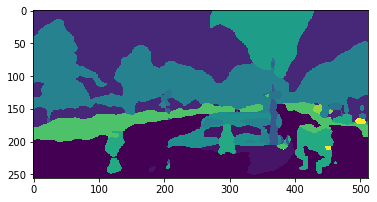

In [2]:
import yaml
import torch
import argparse
import timeit
import numpy as np

from torch.utils import data


from ptsemseg.models import get_model
from ptsemseg.loader import get_loader
from ptsemseg.metrics import runningScore
from ptsemseg.utils import convert_state_dict
import cv2
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True


def validate():

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Setup Model
    cfg_model = dict()
    cfg_model["arch"] = "fcn8s"
    model_path = "runs/fcn8s_cityscapes/20191210_1900/fcn8s_cityscapes_best_model.pkl"
    
    model = get_model(cfg_model, 19).to(device)
    state = convert_state_dict(torch.load(model_path)["model_state"])
    model.load_state_dict(state)
    model.eval()
    model.to(device)
    
    image = cv2.imread("test.png")
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.normalize(image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    image = np.float32(image)
    print(image)
    image = np.transpose(image, (2, 0, 1))
    image = np.reshape(image, (1, 3, 256, 512))
    print(image.shape)
 
    image_tensor = torch.from_numpy(image)

#     for i, (images, labels) in enumerate(valloader):
#         start_time = timeit.default_timer()
    image_tensor = image_tensor.to(device)

#     if args.eval_flip:
    outputs = model(image_tensor)

        # Flip images in numpy (not support in tensor)
    outputs = outputs.data.cpu().numpy()
    flipped_images = np.copy(image_tensor.data.cpu().numpy()[:, :, :, ::-1])
    flipped_images = torch.from_numpy(flipped_images).float().to(device)
    outputs_flipped = model(flipped_images)
    outputs_flipped = outputs_flipped.cpu().data.numpy()
    outputs = (outputs + outputs_flipped[:, :, :, ::-1]) / 2.0
    print(outputs[0, :, 0, 0])
    outputs = np.reshape(outputs, (19, 256, 512))
    outputs = np.transpose(outputs, (1, 2, 0))
    print(outputs.shape)
    res = np.zeros((256, 512))
    for i in range(256):
        for j in range(512):
            output = outputs[i,j,:]
            index = np.where(output == max(output))
            res[i][j] = index[0][0]
    print(np.where(res == 8))
    plt.imshow(res)
    plt.show()

if __name__ == "__main__":
    validate()
